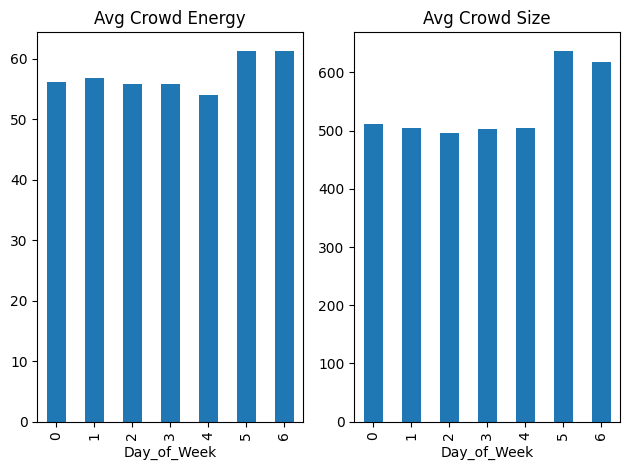

crowd size for tuesday is lesser than mean 


In [125]:
import pandas as pd
import numpy as np

def convert_to_usd(price):
    if pd.isna(price):
        return np.nan

    price = str(price).strip()

    if "free" in price.lower():
        return 0.0
    
    if "vip" in price.lower():
        return np.nan

    price = price.replace("USD", "").replace("usd", "").strip()

    if price.startswith("£"):
        return float(price[1:]) * 1.27
    
    elif price.startswith("€"):
        return float(price[1:]) * 1.09
    elif price.startswith("$"):
        return float(price[1:])
    else:
        return float(price)




def time_of_day(hour):
    if pd.isna(hour):
        return "Morning"
    hour = int(hour)
    if 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    elif hour <= 3 or hour >= 21:
        return "Night"
    else:
        return "Morning"

import matplotlib.pyplot as plt

df = pd.read_csv('tour_logs_train.csv')

# currrency conversion
df["Ticket_Price_USD"] = df["Ticket_Price"].apply(convert_to_usd)


#date time correction 
df['Show_DateTime'] = pd.to_datetime(
    df['Show_DateTime'],format='mixed',dayfirst=True,errors='coerce')


#filling of missing volume level and crowd size by their mean

venues = ["V_Alpha", "V_Beta", "V_Gamma", "V_Delta"]
cols = ["Crowd_Size", "Volume_Level"]

df.loc[df["Venue_ID"].isin(venues), cols] = (
    df.loc[df["Venue_ID"].isin(venues)]
      .groupby("Venue_ID")[cols]
      .transform(lambda x: x.fillna(x.mean()))
)

df=df.dropna(subset=["Show_DateTime"])




#removing irelavent rows with immposible values
df = df[
    (df['Crowd_Size'] ).between(1,2000) &
    (df['Volume_Level'].between(1, 100)) &
    (df['Day_of_Week']).between(0,6)&
    (df['Crowd_Energy']).between(1,99)&
    (df['Merch_Sales_Post_Show']>=0)&
    (df['Opener_Rating'].between(1,5))

]

Alpha = df[df["Venue_ID"]=="V_Alpha"]
Beta  = df[df["Venue_ID"]=="V_Beta"]
Gamma = df[df["Venue_ID"]=="V_Gamma"]
Delta = df[df["Venue_ID"]=="V_Delta"]


df.to_csv(
   'outpur.csv',index=False)

fig, axes = plt.subplots(1, 2)

df.groupby("Day_of_Week")["Crowd_Energy"].mean().plot(
    kind="bar", ax=axes[0], title="Avg Crowd Energy"
)

df.groupby("Day_of_Week")["Crowd_Size"].mean().plot(
    kind="bar", ax=axes[1], title="Avg Crowd Size"
)

plt.tight_layout()
plt.show()

tues=df[df['Day_of_Week']==2]
if (tues["Crowd_Energy"].mean()>df["Crowd_Energy"].mean()) :
    print("crowd size for tuesday is greater than mean")
else :
    print("crowd size for tuesday is lesser than mean ")




    





 

# tuesday curse

The **Tuesday hypothesis** of Narattar is **rejected**, as Tuesday’s mean Crowd Energy and Crowd Size are only slightly lower and not significantly below the overall mean.

# weekend vs weekday 

In contrast, weekends show signifantly higher mean(global) Crowd Energy (by)and Crowd Size, indicating increased engagement compared to weekdays.


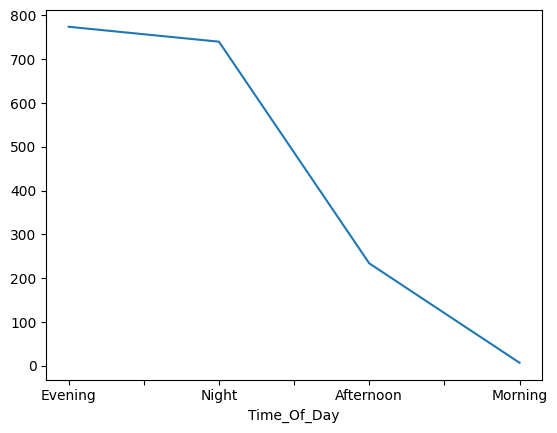

In [126]:
df["Time_Of_Day"] = df["Show_DateTime"].dt.hour.apply(time_of_day)    # another column for feature engeneering
time_counts = df["Time_Of_Day"].value_counts()
time_counts.plot()
plt.show()

### crowd_Size vs Time_of_Day realtion

the **narrators hyposthesis** is expected for train is **acccepted** by visulisation  and shows hisher crowd size at evening and night than Afternoon significantly

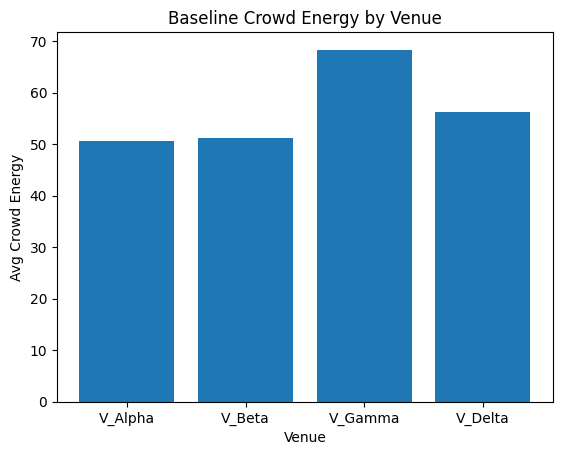

In [127]:
baseline_energy = {
    "V_Alpha": Alpha["Crowd_Energy"].mean(),
    "V_Beta":  Beta["Crowd_Energy"].mean(),
    "V_Gamma": Gamma["Crowd_Energy"].mean(),
    "V_Delta": Delta["Crowd_Energy"].mean(),
}

plt.bar(baseline_energy.keys(), baseline_energy.values())
plt.xlabel("Venue")
plt.ylabel("Avg Crowd Energy")
plt.title("Baseline Crowd Energy by Venue")
plt.show()


### Baseline energy vs Venue 
(V_Gamma: Venue) shws specific crowd energy significantly more value than mean global crowd energy 



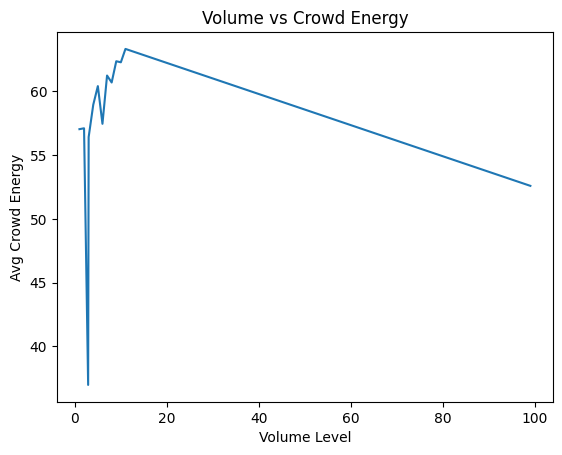

In [128]:
volume_energy = (
    df.groupby("Volume_Level")["Crowd_Energy"]
      .mean()
)

plt.plot(volume_energy.index, volume_energy.values)
plt.xlabel("Volume Level")
plt.ylabel("Avg Crowd Energy")
plt.title("Volume vs Crowd Energy")
plt.show()

# the global volume vs crowd energy analysis 
the crowd energy shows a fluctution (0 to 17 approx. ) and then shows a linar decrease in crowd energy as volume level increases 

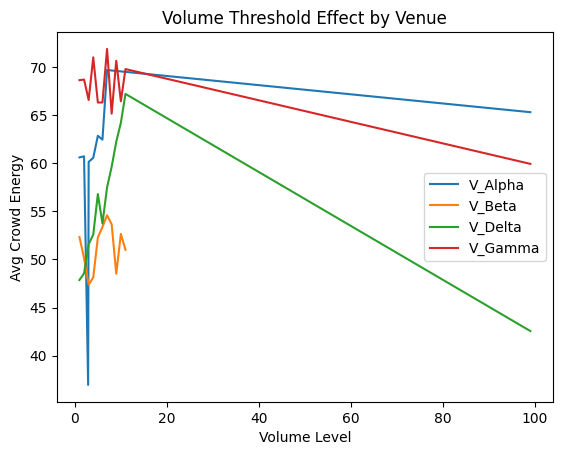

In [129]:
venue_volume_energy = (
    df.groupby(["Venue_ID", "Volume_Level"])["Crowd_Energy"]
      .mean()
      .reset_index()
)

for venue in df["Venue_ID"].unique():
    subset = venue_volume_energy[venue_volume_energy["Venue_ID"] == venue]
    
    plt.plot(subset["Volume_Level"], subset["Crowd_Energy"], label=venue)

plt.xlabel("Volume Level")
plt.ylabel("Avg Crowd Energy")
plt.title("Volume Threshold Effect by Venue")
plt.legend()
plt.show()

### venue vise crowd energy vs volume level analysis 
all venues shows fluction of crowd energytill (approx. 17 volume level) and then shows a gradual decrease by **except** vampires den (V_Beta) shows that Volume level is restricted to go above 20

## Model formation and training 

# model justification

Ridge regressionbecause it is simple, and just like simple regression and works well with noisy data.  reduces overfitting through regularization and provides stable predictions. sorry the model dosent works properly

In [130]:
import pandas as pd
import numpy as np



y = df["Crowd_Energy"]

X = df.drop(columns=[
    "Crowd_Energy",
    "Merch_Sales_Post_Show",
    "Volume_Level",
    "Show_DateTime",

], errors="ignore")

X = X.replace([np.inf, -np.inf], np.nan).fillna(0)


from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

preprocessor = ColumnTransformer(
    [
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

model = Pipeline([
    ("prep", preprocessor),
    ("ridge", Ridge())
])

param_grid = {
    "ridge__alpha": [0.1, 1, 10, 50]
}

grid = GridSearchCV(
    model,
    param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5
)

grid.fit(X_train, y_train)

val_preds = grid.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, val_preds))

print("Best alpha:", grid.best_params_)
print("Validation RMSE:", rmse)

final_model = grid.best_estimator_
final_model.fit(X, y)

test_df = pd.read_csv("tour_logs_test_input.csv")

test_df["Ticket_Price_USD"] = test_df["Ticket_Price"].apply(convert_to_usd)
test_df["Show_DateTime"] = pd.to_datetime(test_df["Show_DateTime"], errors="coerce")
test_df["Show_Hour"] = pd.to_numeric(test_df["Show_DateTime"].dt.hour, errors="coerce")
test_df["Time_Of_Day"] = test_df["Show_Hour"].apply(time_of_day)

test_df = test_df.drop(columns=[
    "Merch_Sales_Post_Show",
    "Volume_Level",
    "Show_DateTime",
    "Show_Hour",
    "Ticket_Price"
], errors="ignore")

test_df = test_df.replace([np.inf, -np.inf], np.nan).fillna(0)


test_df = test_df.reindex(columns=X.columns, fill_value=0)

predictions = final_model.predict(test_df)

pd.DataFrame({"Crowd_Energy": predictions}).to_csv(
    "predictions.csv", index=False
)


Best alpha: {'ridge__alpha': 10}
Validation RMSE: 14.571185800898581


TypeError: '<' not supported between instances of 'int' and 'str'